In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

csfont = {'fontname':'Times New Roman'}

# Fig 3

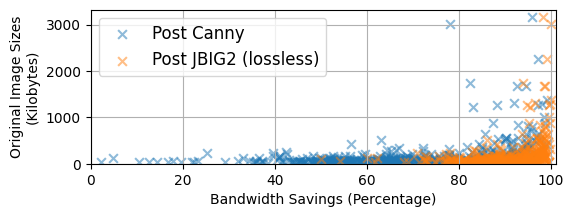

In [69]:
df = pd.read_csv("image_compression.csv")

dataset_image_sizes_kB = df['original_image_size'] / 1024
canny_images_reduction = df['canny_image_percentage_reduction']
jbig2_images_reduction = df['jbig2_image_percentage_reduction']

plt.figure(figsize=(6, 2))

plt.scatter(canny_images_reduction, dataset_image_sizes_kB, label='Post Canny', marker='x', s=40, alpha=0.5)
plt.scatter(jbig2_images_reduction, dataset_image_sizes_kB, label='Post JBIG2 (lossless)', marker='x', s=40, alpha=0.5)

plt.ylabel('Original Image Sizes\n(Kilobytes)')
plt.xlabel('Bandwidth Savings (Percentage)')
plt.legend(fontsize='large')
plt.xlim(0, 101)
plt.ylim(0)

plt.grid(True)
plt.savefig('3.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Fig 4.1

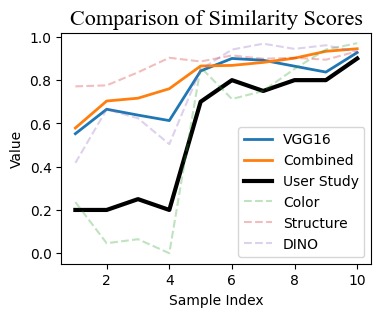

In [83]:
df = pd.read_csv('scores_comparison.csv')

df = df[df['STUDY'] == 2]

df['Structure'] = df['Structure'].clip(upper=1)
df['Structure'] = df['Structure'].clip(lower=0)
df['Color'] = df['Color'].clip(upper=1)
df['Color'] = df['Color'].clip(lower=0)
df['DINO'] = df['DINO'].clip(upper=1)
df['DINO'] = df['DINO'].clip(lower=0)

def contraharmonic_mean_three_numbers(num1, num2, num3):
    return (num1 ** 2 + num2 ** 2 + num3 ** 2) / (num1 + num2 + num3)

df['COMB'] = df.apply(lambda row: contraharmonic_mean_three_numbers(1 - row['Structure'], row['Color'], row['DINO']), axis=1)

# randomly sample exp_data
exp_data = df.sample(10, random_state=42)
exp_data = exp_data.sort_values(by='COMB')
exp_data.index = np.arange(1, len(exp_data) + 1)

plt.figure(figsize=(4, 3))

plt.plot(exp_data.index, exp_data['VGG16'], label='VGG16', linestyle='-', linewidth=2)
plt.plot(exp_data.index, exp_data['COMB'], label='Combined', linestyle='-', linewidth=2)
plt.plot(exp_data.index, exp_data['USER'], label='User Study', linestyle='-', linewidth=3, color='black')

plt.plot(exp_data.index, exp_data['Color'], label='Color', linestyle='--', alpha=0.3)
plt.plot(exp_data.index, 1-exp_data['Structure'], label='Structure', linestyle='--', alpha=0.3)
plt.plot(exp_data.index, exp_data['DINO'], label='DINO', linestyle='--', alpha=0.3)

plt.title('Comparison of Similarity Scores', fontsize=16, **csfont)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend(loc='lower right')
plt.show()

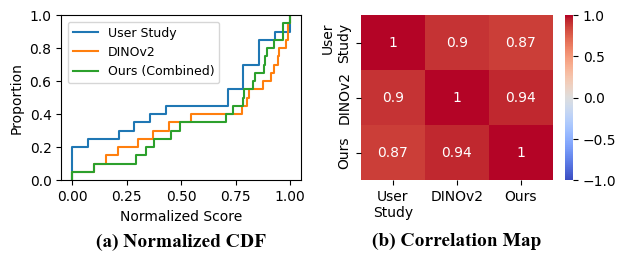

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6.5, 3))

metrics = ['USER', 'DINO', 'COMB']
labels = {
    'USER':'User Study',
    'DINO':'DINOv2',
    'COMB':'Ours (Combined)',
    'SSIM':'SSIM',
}
for metric in metrics:
    normalized_metric = (df[metric] - df[metric].min()) / (df[metric].max() - df[metric].min())
    sns.ecdfplot(normalized_metric, ax=ax1, label=labels[metric])

ax1.set_title('(a) Normalized CDF', **csfont, fontweight='bold', fontsize=14, y=-0.45)
ax1.set_xlabel('Normalized Score')
ax1.legend(fontsize=9)

correlation_matrix = df[metrics].corr()
correlation_matrix.index = ['User\nStudy', 'DINOv2', 'Ours']
correlation_matrix.columns = ['User\nStudy', 'DINOv2', 'Ours']
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=ax2)
ax2.set_title('(b) Correlation Map', **csfont, fontweight='bold', fontsize=14, y=-0.45)

plt.tight_layout()
plt.savefig('4.1.pdf', dpi=300, bbox_inches='tight')
plt.show()

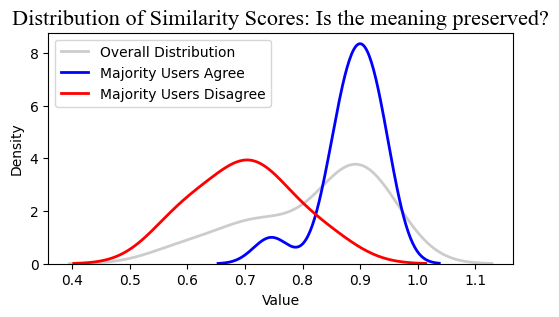

In [122]:
plt.figure(figsize=(6, 3))

sns.kdeplot(df['COMB'], label='Overall Distribution', color='black', linewidth=2, alpha=0.2)
sns.kdeplot(df[df['USER_MEANING'] > 0.5]['COMB'], label='Majority Users Agree', color='blue', linewidth=2)
sns.kdeplot(df[df['USER_MEANING'] < 0.5]['COMB'], label='Majority Users Disagree', color='red', linewidth=2)

plt.title('Distribution of Similarity Scores: Is the meaning preserved?', fontsize=16, **csfont)
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()


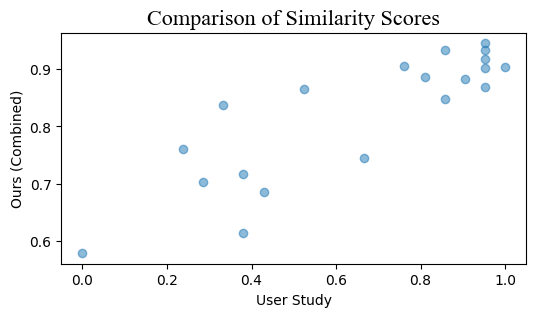

In [104]:
plt.figure(figsize=(6, 3))

plt.scatter(df['USER_MEANING'], df['COMB'], alpha=0.5)
plt.xlabel('User Study')
plt.ylabel('Ours (Combined)')
plt.title('Comparison of Similarity Scores', fontsize=16, **csfont)
plt.show()

In [89]:
correlation_with_meaning = df[['COMB', 'USER_MEANING']].corr().iloc[0, 1]

# exclude rows with NaN USER_PREF
df2 = df.dropna(subset=['USER_PREF'])
correlation_with_pref = df2[['COMB', 'USER_PREF']].corr().iloc[0, 1]

print(f"Correlation of COMB with USER_MEANING: {correlation_with_meaning}")
print(f"Correlation of COMB with USER_PREF: {correlation_with_pref}")

Correlation of COMB with USER_MEANING: 0.8551711595901244
Correlation of COMB with USER_PREF: 0.4119713946072613


# Fig 4.2

In [18]:
sizes = pd.read_csv('sizes.csv')
scores = pd.read_csv('scores.csv')

df = pd.merge(sizes, scores, on=['EXP', 'IMG'])
df

,EXP,IMG,RESOLUTION,ORIGINAL_BYTES,NEW_BYTES,SAVINGS,BPP,IMG1,IMG2,VGG16,Structure,Color,CLIP,DINO
0,C,001.webp,696320,65164,4249,93.479529,0.048817,ds_combined_resized1024\001.webp,recon_C2\001.webp,0.826579,0.062260,-0.055599,0.932822,0.841334
1,C,002.webp,696320,137806,9687,92.970553,0.111294,ds_combined_resized1024\002.webp,recon_C2\002.webp,0.676901,0.080852,0.142201,0.883915,0.761238
2,C,003.webp,843776,544044,22570,95.851438,0.213990,ds_combined_resized1024\003.webp,recon_C2\003.webp,0.746600,0.099824,0.344150,0.933543,0.849075
3,C,004.webp,696320,58140,5576,90.409357,0.064062,ds_combined_resized1024\004.webp,recon_C2\004.webp,0.843735,0.073964,0.221405,0.907679,0.788373
4,C,005.webp,696320,438440,43087,90.172658,0.495025,ds_combined_resized1024\005.webp,recon_C2\005.webp,0.806303,0.056204,0.146932,0.907416,0.681747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,P,zoom.us_005.jpg,581632,177428,34,99.980837,0.000468,ds_combined_resized1024\zoom.us_005.jpg,recon_P2\zh.m.wikipedia.org_066.jpg,0.579017,0.175333,0.086904,0.523877,0.275458
1716,P,zoom.us_015.jpg,352640,57848,277,99.521159,0.006284,ds_combined_resized1024\zoom.us_015.jpg,recon_P2\zoom.us_005.jpg,0.588285,0.094964,0.032272,0.746645,0.291187
1717,P,zoom.us_022.jpg,352640,10298,93,99.096912,0.002110,ds_combined_resized1024\zoom.us_022.jpg,recon_P2\zoom.us_015.jpg,0.439420,0.198874,-0.003506,0.526777,0.061913
1718,P,zoom.us_059.jpg,581632,138925,208,99.850279,0.002861,ds_combined_resized1024\zoom.us_059.jpg,recon_P2\zoom.us_022.jpg,0.262702,0.124561,-0.200766,0.384791,0.166638


In [19]:
df['Structure'] = df['Structure'].clip(upper=1)
df['Structure'] = df['Structure'].clip(lower=0)
df['Color'] = df['Color'].clip(upper=1)
df['Color'] = df['Color'].clip(lower=0)
df['DINO'] = df['DINO'].clip(upper=1)
df['DINO'] = df['DINO'].clip(lower=0)

def contraharmonic_mean_three_numbers(num1, num2, num3):
    return (num1 ** 2 + num2 ** 2 + num3 ** 2) / (num1 + num2 + num3)

df['COMB'] = df.apply(lambda row: contraharmonic_mean_three_numbers(1 - row['Structure'], row['Color'], row['DINO']), axis=1)

In [20]:
exp_mapping = {
    'P': 'Prompt only',
    'C': 'Prompt + Canny',
    'NS': 'Prompt + Canny + Color',
    'S': 'Salient Features'
}

df['Experiment'] = df['EXP'].map(exp_mapping)

grouped = df.groupby('Experiment').agg({
    'COMB': ['median', 'min', 'max'],
    'SAVINGS': ['median', 'min', 'max'],
    'BPP': ['median', 'min', 'max'],
})

grouped.columns = ['_'.join(col).strip() for col in grouped.columns.values]
grouped.reset_index(inplace=True)

grouped

,Experiment,COMB_median,COMB_min,COMB_max,SAVINGS_median,SAVINGS_min,SAVINGS_max,BPP_median,BPP_min,BPP_max
0,Prompt + Canny,0.697706,0.087652,0.926305,91.139231,53.995185,99.948892,0.170956,0.004995,0.930607
1,Prompt + Canny + Color,0.862405,0.102521,0.967597,90.467716,52.909003,99.943231,0.184807,0.005987,0.935800
2,Prompt only,0.692785,0.053823,0.900058,99.777791,83.997509,99.999301,0.004126,0.000099,0.022586


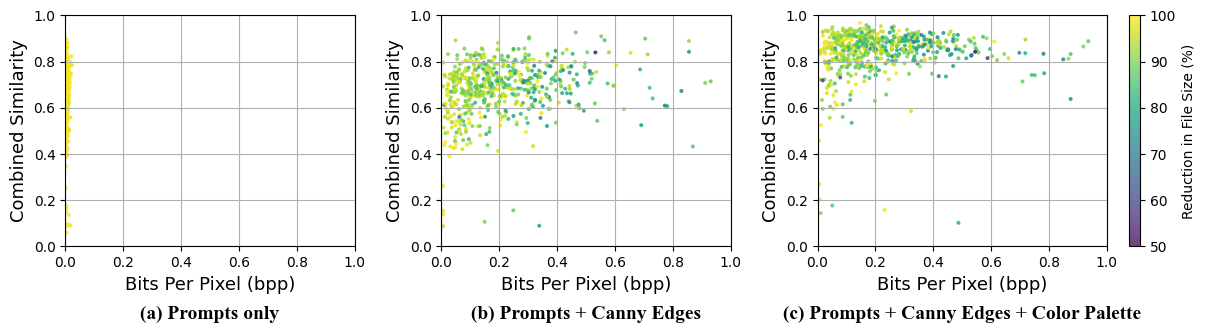

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.3)
# fig.text(0.5, -0.05, 'Bits Per Pixel', ha='center', fontsize=13)
# fig.text(0.08, 0.5, 'Combined Similarity Score', va='center', rotation='vertical', fontsize=10)

for (exp, ax, title) in zip(['P', 'C', 'NS'], axes, [
    "(a) Prompts only",
    "(b) Prompts + Canny Edges",
    "(c) Prompts + Canny Edges + Color Palette"
]):
    scatter = ax.scatter(df[df['EXP'] == exp]['BPP'], df[df['EXP'] == exp]['COMB'], alpha=0.75, marker='.', c=df[df['EXP'] == exp]['SAVINGS'], cmap='viridis', s=15)
    scatter.set_clim(50, 100)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xlabel('Bits Per Pixel (bpp)', fontsize=13)
    ax.set_ylabel('Combined Similarity', fontsize=13)
    ax.set_title(title, **csfont, fontweight='bold', fontsize=14, y=-0.35)
    ax.grid(True)

cbar = fig.colorbar(scatter, ax=axes, orientation='vertical', fraction=0.02, pad=0.02)
cbar.set_label("Reduction in File Size (%)")

plt.savefig('4.2.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Fig 4.3

C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\970675259.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x=technique_labels, y=plot_data[i], palette=custom_palette)
C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\970675259.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x=technique_labels, y=plot_data[i], palette=custom_palette)
C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\970675259.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, x=technique_labels, y=plot_data[i], palette=custom_palette)


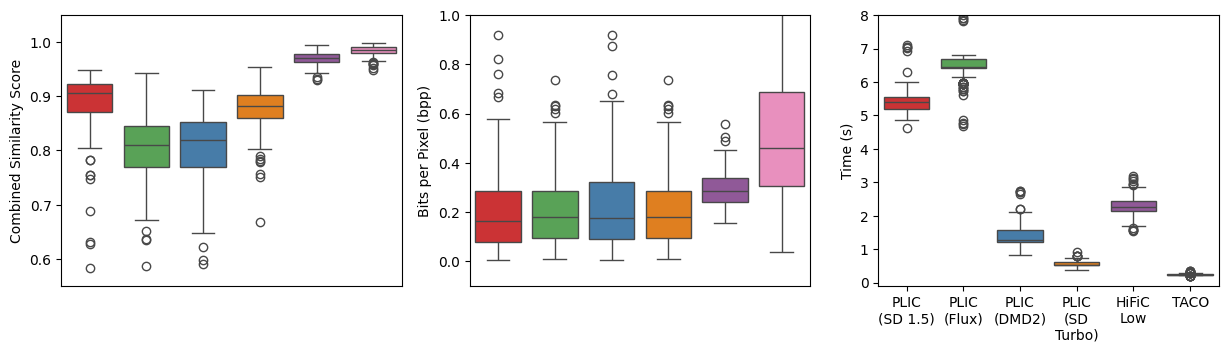

In [22]:
df = pd.read_csv('model_comparisons.csv')

contraharmonic_scores = df['sd_contraharmonic_scores'].tolist()[1:] + df['flux_contraharmonic_scores'].tolist()[1:] + \
                        df['dmd2_contraharmonic_scores'].tolist()[1:] + df['sdturbo_contraharmonic_scores'].tolist()[1:] + \
                        df['hific_low_contraharmonic_scores'].tolist()[1:] + df['taco_contraharmonic_scores'].tolist()[1:]

bpp_scores = df['sd_bpp'].tolist()[1:] + df['flux_bpp'].tolist()[1:] + \
             df['dmd2_bpp'].tolist()[1:] + df['sdturbo_bpp'].tolist()[1:] + \
             df['hific_low_bpp'].tolist()[1:] + df['taco_bpp'].tolist()[1:]

generation_times = df['sd_generation_times'].tolist()[1:] + df['flux_generation_times'].tolist()[1:] + \
                   df['dmd2_generation_times'].tolist()[1:] + df['sdturbo_generation_times'].tolist()[1:] + \
                   df['hific_low_generation_times'].tolist()[1:] + df['taco_generation_times'].tolist()[1:]

techniques = ['PLIC\n(SD 1.5)', 'PLIC\n(Flux)', 'PLIC\n(DMD2)', 'PLIC\n(SD\nTurbo)', 'HiFiC\nLow', 'TACO']
num_data_points = 147

technique_labels = [tech for tech in techniques for _ in range(num_data_points)]

custom_palette = {
    'PLIC\n(SD 1.5)': '#e41a1c',
    'PLIC\n(Flux)': '#4daf4a',
    'PLIC\n(DMD2)': '#377eb8',
    'PLIC\n(SD\nTurbo)': '#ff7f00',
    'HiFiC\nLow': '#984ea3',
    'TACO': '#f781bf'
}

technique_labels = pd.Categorical(technique_labels, categories=custom_palette.keys())

fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharey=False)
fig.tight_layout(pad=0)

plot_titles = ['(a) Combined Similarity Scores', '(b) Compression Power', '(c) Generation Times']
y_labels = ['Combined Similarity Score', 'Bits per Pixel (bpp)', 'Time (s)']
y_limits = [(0.55, 1.05), (-0.1, 1), (-0.1, 8)]

plot_data = [contraharmonic_scores, bpp_scores, generation_times]

for i, ax in enumerate(axs):
    sns.boxplot(ax=ax, x=technique_labels, y=plot_data[i], palette=custom_palette)
    ax.set_ylabel(y_labels[i])
    ax.set_ylim(y_limits[i])
    if i != 2:
        ax.set_xticks([])
        # ax.set_title(plot_titles[i], **csfont, fontweight='bold', fontsize=14, y=-0.18)
    # else:
        # ax.set_title(plot_titles[i], **csfont, fontweight='bold', fontsize=14, y=-0.45)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
# plt.savefig('4.3.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\3966733971.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, y=technique_labels, x=plot_data[i], palette=custom_palette, linewidth=1, width=0.5)
C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\3966733971.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, y=technique_labels, x=plot_data[i], palette=custom_palette, linewidth=1, width=0.5)
C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\3966733971.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=ax, y=technique_l

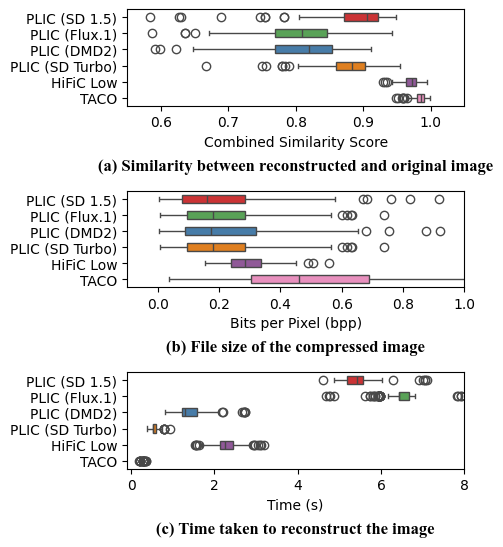

In [139]:
df = pd.read_csv('model_comparisons.csv')

contraharmonic_scores = df['sd_contraharmonic_scores'].tolist()[1:] + df['flux_contraharmonic_scores'].tolist()[1:] + \
                        df['dmd2_contraharmonic_scores'].tolist()[1:] + df['sdturbo_contraharmonic_scores'].tolist()[1:] + \
                        df['hific_low_contraharmonic_scores'].tolist()[1:] + df['taco_contraharmonic_scores'].tolist()[1:]

bpp_scores = df['sd_bpp'].tolist()[1:] + df['flux_bpp'].tolist()[1:] + \
             df['dmd2_bpp'].tolist()[1:] + df['sdturbo_bpp'].tolist()[1:] + \
             df['hific_low_bpp'].tolist()[1:] + df['taco_bpp'].tolist()[1:]

generation_times = df['sd_generation_times'].tolist()[1:] + df['flux_generation_times'].tolist()[1:] + \
                   df['dmd2_generation_times'].tolist()[1:] + df['sdturbo_generation_times'].tolist()[1:] + \
                   df['hific_low_generation_times'].tolist()[1:] + df['taco_generation_times'].tolist()[1:]

custom_palette = {
    'PLIC (SD 1.5)': '#e41a1c',
    'PLIC (Flux.1)': '#4daf4a',
    'PLIC (DMD2)': '#377eb8',
    'PLIC (SD Turbo)': '#ff7f00',
    'HiFiC Low': '#984ea3',
    'TACO': '#f781bf'
}

techniques = custom_palette.keys()
num_data_points = 147

technique_labels = [tech for tech in techniques for _ in range(num_data_points)]

technique_labels = pd.Categorical(technique_labels, categories=custom_palette.keys())

fig, axs = plt.subplots(3, 1, figsize=(5, 6), sharey=False)
fig.tight_layout(pad=4)

plot_titles = ['(a) Similarity between reconstructed and original image', '(b) File size of the compressed image', '(c) Time taken to reconstruct the image']
y_labels = ['Combined Similarity Score', 'Bits per Pixel (bpp)', 'Time (s)']
y_limits = [(0.55, 1.05), (-0.1, 1), (-0.1, 8)]

plot_data = [contraharmonic_scores, bpp_scores, generation_times]

for i, ax in enumerate(axs):
    sns.boxplot(ax=ax, y=technique_labels, x=plot_data[i], palette=custom_palette, linewidth=1, width=0.5)
    ax.set_xlabel(y_labels[i])
    ax.set_xlim(y_limits[i])
    ax.set_title(plot_titles[i], **csfont, fontweight='bold', fontsize=12, y=-0.75)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the plot
plt.savefig('4.3.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Fig 4.4

C:\Users\Danish\AppData\Local\Temp\ipykernel_15396\1060780604.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


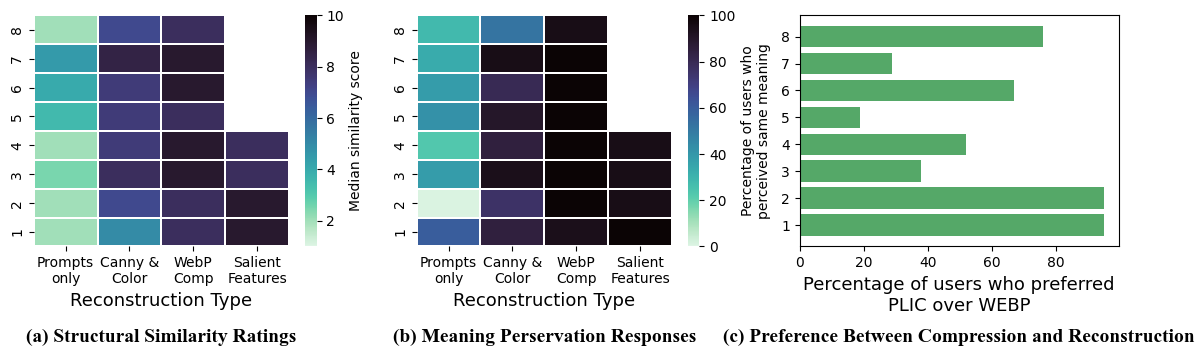

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 3), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0.2)
# fig.text(0.5, -0.05, 'Bits Per Pixel', ha='center', fontsize=13)
# fig.text(0.08, 0.5, 'Combined Similarity Score', va='center', rotation='vertical', fontsize=10)

data = np.array([
    [2, 7, 8, 0], # image 1
    [4.5, 8.5, 9, 0], # image 5
    [4, 7.5, 9, 0], # image 2
    [3.5, 7.5, 8, 0], # image 8
    [2, 7.5, 9, 8], # image 3
    [2.5, 8, 9, 8], # image 7
    [2, 7, 8, 9], # image 4
    [2, 5, 8, 9] # image 6
])

websites = [f'{i}' for i in range(8, 0, -1)]
reductions = ['Prompts\nonly', 'Canny &\nColor', 'WebP\nComp', 'Salient\nFeatures']

df = pd.DataFrame(data, index=websites, columns=reductions)
cmap = sns.color_palette("mako_r", as_cmap=True)
cmap.set_under('white')

sns.heatmap(ax=ax1, data=df, annot=False, cmap=cmap, cbar=True, vmin=1, vmax=10, linewidths=0.01, linecolor='white', cbar_kws={'label': 'Median similarity score'})
ax1.set_xlabel('Reconstruction Type', fontsize=13)
# ax1.set_ylabel('Image source and type', fontsize=13)
ax1.set_title('(a) Structural Similarity Ratings', **csfont, fontweight='bold', fontsize=14, y=-0.45)

# Sample data similar to the image provided
data = np.array([
    [28, 52, 95, -1], # image 1
    [33, 95, 100, -1], # image 5
    [38, 80, 100, -1], # image 2
    [42, 90, 100, -1], # image 8
    [23, 85, 100, 95], # image 3
    [38, 94, 100, 95], # image 7
    [1, 76, 100, 95], # image 4
    [60, 85, 94, 100] # image 6
])

df = pd.DataFrame(data, index=websites, columns=reductions)
cmap = sns.color_palette("mako_r", as_cmap=True)
cmap.set_under('white')

sns.heatmap(ax=ax2, data=df, annot=False, cmap=cmap, cbar=True, vmin=0, vmax=100, linewidths=0.01, linecolor='white', cbar_kws={'label': 'Percentage of users who\nperceived same meaning'})
ax2.set_xlabel('Reconstruction Type', fontsize=13)
# ax2.set_ylabel('Image source and type', fontsize=13)
ax2.set_title('(b) Meaning Perservation Responses', **csfont, fontweight='bold', fontsize=14, y=-0.45)

data = [76, 29, 67, 19, 52, 38, 95, 95][::-1]

ax3.barh([f"{i+1}" for i in range(len(data[::-1]))], data, color='#55A868')
ax3.set_xlabel('Percentage of users who preferred\nPLIC over WEBP', fontsize=13)
ax3.set_title('(c) Preference Between Compression and Reconstruction', **csfont, fontweight='bold', fontsize=14, y=-0.45)

fig.savefig('4.4.pdf', dpi=300, bbox_inches='tight')
fig.show()

# Extra

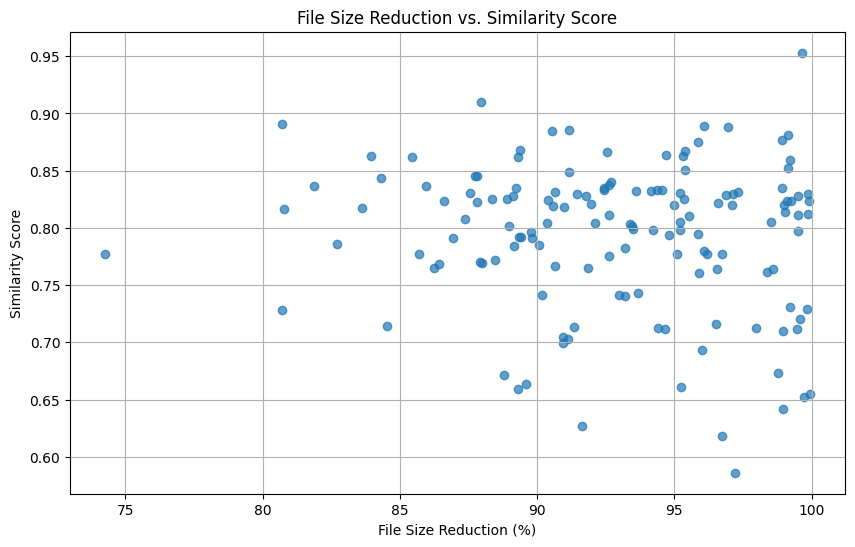

Pearson Correlation Coefficient: -0.11 (p-value: 0.2071)


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Load the data
sizes_df = pd.read_csv('sizes.csv')
scores_df = pd.read_csv('sd_turbo_scores_comb.csv')

# Merge datasets on image name
merged_df = pd.merge(sizes_df[sizes_df['EXP'] == 'C'], scores_df, on='IMG')

# Extract relevant columns
file_size_reduction = merged_df['SAVINGS']
similarity_scores = merged_df['COMB']

# Scatter plot
plt.figure(figsize=(10,6))
plt.scatter(file_size_reduction, similarity_scores, alpha=0.7)
plt.title('File Size Reduction vs. Similarity Score')
plt.xlabel('File Size Reduction (%)')
plt.ylabel('Similarity Score')
plt.grid(True)
plt.show()

# Calculate correlation coefficient
corr_coef, p_value = pearsonr(file_size_reduction, similarity_scores)
print(f"Pearson Correlation Coefficient: {corr_coef:.2f} (p-value: {p_value:.4f})")


In [81]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Load the data
gpu_df = pd.read_csv('gpu_sd_turbo.csv', parse_dates=['TIME'], date_parser=lambda x: datetime.fromtimestamp(float(x)))
times_df = pd.read_csv('times_sd_turbo.csv', parse_dates=['START', 'END'], date_parser=lambda x: datetime.fromtimestamp(float(x)))

# Function to calculate energy consumption for each image
def calculate_energy(start_time, end_time):
    mask = (gpu_df['TIME'] >= start_time) & (gpu_df['TIME'] <= end_time)
    power_values = gpu_df.loc[mask, 'GPU'].values  # in watts
    time_deltas = gpu_df.loc[mask, 'TIME'].diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds().values
    energy = np.sum(power_values * time_deltas)  # in watt-seconds (joules)
    return energy

# Calculate energy consumption per image
times_df['ENERGY_J'] = times_df.apply(lambda row: calculate_energy(row['START'], row['END']), axis=1)

# Convert energy to kWh (1 kWh = 3.6e6 joules)
times_df['ENERGY_kWh'] = times_df['ENERGY_J'] / 3.6e6

# Display results
print(times_df[['IMG', 'ENERGY_kWh']])

          IMG  ENERGY_kWh
0    001.webp    0.000040
1    002.webp    0.000041
2    003.webp    0.000052
3    004.webp    0.000041
4    005.webp    0.000034
..        ...         ...
143   146.jpg    0.000038
144   147.jpg    0.000053
145   148.jpg    0.000041
146   149.jpg    0.000031
147   150.jpg    0.000043

[148 rows x 2 columns]


C:\Users\Danish\AppData\Local\Temp\ipykernel_26056\989632553.py:6: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  gpu_df = pd.read_csv('gpu_sd_turbo.csv', parse_dates=['TIME'], date_parser=lambda x: datetime.fromtimestamp(float(x)))
C:\Users\Danish\AppData\Local\Temp\ipykernel_26056\989632553.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  times_df = pd.read_csv('times_sd_turbo.csv', parse_dates=['START', 'END'], date_parser=lambda x: datetime.fromtimestamp(float(x)))


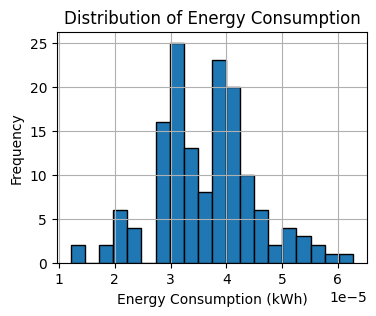

In [82]:
# plot distribution of energy consumption
plt.figure(figsize=(4,3))
plt.hist(times_df['ENERGY_kWh'], bins=20, edgecolor='black')
plt.title('Distribution of Energy Consumption')
plt.xlabel('Energy Consumption (kWh)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [83]:
# Load the data
data_prices_df = pd.read_csv('data_prices.csv', encoding='ISO-8859-1')
sizes_df = pd.read_csv('sizes.csv')

# Filter data_prices_df for 'Data-only mobile-broadband basket' and 'USD'
data_prices_filtered = data_prices_df[
    (data_prices_df['basket_combined_simplified'] == 'Data-only mobile-broadband basket') &
    (data_prices_df['Unit'] == 'USD')
]

# Assume data prices are per 2GB, calculate cost per byte
data_prices_filtered['Cost_per_Byte'] = data_prices_filtered['2023'] / (2 * 1024 * 1024 * 1024)

# Calculate transmission costs
sizes_df['Original_Cost_USD'] = sizes_df['ORIGINAL_BYTES'] * data_prices_filtered['Cost_per_Byte'].mean()
sizes_df['New_Cost_USD'] = sizes_df['NEW_BYTES'] * data_prices_filtered['Cost_per_Byte'].mean()
sizes_df['Cost_Savings_USD'] = sizes_df['Original_Cost_USD'] - sizes_df['New_Cost_USD']

# Display results
print(sizes_df[['IMG', 'Original_Cost_USD', 'New_Cost_USD', 'Cost_Savings_USD']])

                  IMG  Original_Cost_USD  New_Cost_USD  Cost_Savings_USD
0            001.webp           0.000395  2.577001e-05          0.000369
1            002.webp           0.000836  5.875125e-05          0.000777
2            003.webp           0.003300  1.368861e-04          0.003163
3            004.webp           0.000353  3.381821e-05          0.000319
4            005.webp           0.002659  2.613208e-04          0.002398
...               ...                ...           ...               ...
1735  zoom.us_005.jpg           0.001076  2.062086e-07          0.001076
1736  zoom.us_015.jpg           0.000351  1.679993e-06          0.000349
1737  zoom.us_022.jpg           0.000062  5.640411e-07          0.000062
1738  zoom.us_059.jpg           0.000843  1.261511e-06          0.000841
1739  zozo.jp_060.jpg           0.001572  2.037826e-06          0.001570

[1740 rows x 4 columns]


C:\Users\Danish\AppData\Local\Temp\ipykernel_26056\1917241853.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prices_filtered['Cost_per_Byte'] = data_prices_filtered['2023'] / (2 * 1024 * 1024 * 1024)


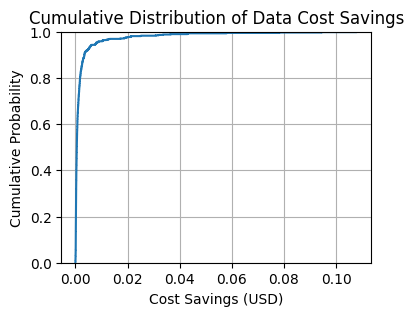

In [77]:
import seaborn as sns

plt.figure(figsize=(4,3))
sns.ecdfplot(sizes_df['Cost_Savings_USD'])
plt.title('Cumulative Distribution of Data Cost Savings')
plt.xlabel('Cost Savings (USD)')
plt.ylabel('Cumulative Probability')
plt.grid(True)
plt.show()

In [72]:
import pandas as pd

# Assuming previous code has been run to define times_df, sizes_df, data_prices_filtered, and so on.

# Check data types in times_df
print("Data types in times_df:")
print(times_df.dtypes)

# Ensure 'ENERGY_kWh' is converted to numeric
times_df['ENERGY_kWh'] = pd.to_numeric(times_df['ENERGY_kWh'], errors='coerce')

# Check for NaN values in 'ENERGY_kWh'
print("\nNumber of NaN values in 'ENERGY_kWh':", times_df['ENERGY_kWh'].isna().sum())

# Inspect any non-numeric values in 'ENERGY_kWh'
non_numeric_values = times_df[times_df['ENERGY_kWh'].isna()]['ENERGY_kWh']
print("\nNon-numeric values in 'ENERGY_kWh':", non_numeric_values.unique())

# Decide how to handle NaN values (drop or fill)
# Option 1: Drop rows with NaN in 'ENERGY_kWh'
times_df = times_df.dropna(subset=['ENERGY_kWh'])

# Option 2: Fill NaN with 0 (if appropriate)
# times_df['ENERGY_kWh'] = times_df['ENERGY_kWh'].fillna(0)

# Verify the data type again
print("\n'ENERGY_kWh' data type after conversion:", times_df['ENERGY_kWh'].dtype)

# Ensure 'electricity_price_cents_per_kWh' is a float
electricity_price_cents_per_kWh = float(electricity_price_cents_per_kWh)
print("\nelectricity_price_cents_per_kWh:", electricity_price_cents_per_kWh)

# Perform the calculation
times_df['Energy_Cost_USD'] = (times_df['ENERGY_kWh'] * electricity_price_cents_per_kWh) / 100

# Proceed with the rest of your code
# Ensure 'ORIGINAL_BYTES' and 'NEW_BYTES' are numeric
times_df['ORIGINAL_BYTES'] = pd.to_numeric(times_df['ORIGINAL_BYTES'], errors='coerce')
times_df['NEW_BYTES'] = pd.to_numeric(times_df['NEW_BYTES'], errors='coerce')

# Handle NaN values in 'ORIGINAL_BYTES' and 'NEW_BYTES'
times_df = times_df.dropna(subset=['ORIGINAL_BYTES', 'NEW_BYTES'])

# Get data cost per byte for the country
data_cost_per_byte = data_prices_filtered.loc[
    data_prices_filtered['IsoCode'] == country_code,
    'Cost_per_Byte'
].values

# Ensure data_cost_per_byte is a float
if len(data_cost_per_byte) > 0:
    data_cost_per_byte = float(data_cost_per_byte[0])
else:
    data_cost_per_byte = data_prices_filtered['Cost_per_Byte'].mean()
    print(f"Country code {country_code} not found in data_prices_filtered. Using average cost per byte.")

print("\ndata_cost_per_byte:", data_cost_per_byte)

# Perform the data cost calculations
times_df['Data_Cost_Original_USD'] = times_df['ORIGINAL_BYTES'] * data_cost_per_byte
times_df['Data_Cost_New_USD'] = times_df['NEW_BYTES'] * data_cost_per_byte

# Total costs
times_df['Total_Cost_Original_USD'] = times_df['Data_Cost_Original_USD']
times_df['Total_Cost_New_USD'] = times_df['Data_Cost_New_USD'] + times_df['Energy_Cost_USD']
times_df['Total_Cost_Savings_USD'] = times_df['Total_Cost_Original_USD'] - times_df['Total_Cost_New_USD']

# Display results
print(times_df[['IMG', 'Total_Cost_Original_USD', 'Total_Cost_New_USD', 'Total_Cost_Savings_USD']].head())


KeyError: 'ENERGY_kWh'

In [84]:
times_df

,IMG,GTIME,START,END,ENERGY_J,ENERGY_kWh
0,001.webp,1.451048,2024-10-11 18:36:07.266736,2024-10-11 18:36:08.717784,145.333527,0.000040
1,002.webp,0.601492,2024-10-11 18:36:09.075730,2024-10-11 18:36:09.677222,147.257845,0.000041
2,003.webp,0.737987,2024-10-11 18:36:10.048383,2024-10-11 18:36:10.786370,187.675754,0.000052
3,004.webp,0.614186,2024-10-11 18:36:10.920046,2024-10-11 18:36:11.534232,146.932258,0.000041
4,005.webp,0.618830,2024-10-11 18:36:11.948387,2024-10-11 18:36:12.567217,120.670732,0.000034
...,...,...,...,...,...,...
143,146.jpg,0.519200,2024-10-11 18:38:00.912616,2024-10-11 18:38:01.431816,138.033984,0.000038
144,147.jpg,0.692027,2024-10-11 18:38:01.769344,2024-10-11 18:38:02.461371,189.444511,0.000053
145,148.jpg,0.618193,2024-10-11 18:38:02.811837,2024-10-11 18:38:03.430029,148.208162,0.000041
146,149.jpg,0.431737,2024-10-11 18:38:03.535618,2024-10-11 18:38:03.967355,110.290060,0.000031


In [87]:
data_prices_filtered

,IsoCode,Economy,basket_combined_simplified,Unit,Code,ITURegion,LDC,LLDC,SIDS,Income_2023,2023


In [85]:
import pandas as pd
import numpy as np

# Load necessary data
data_prices_df = pd.read_csv('data_prices.csv', encoding='ISO-8859-1')
energy_prices_df = pd.read_csv('energy_prices_data.csv', encoding='ISO-8859-1')
sizes_df = pd.read_csv('sizes.csv')
sizes_df = sizes_df[sizes_df['EXP'] == 'C']
# times_df = pd.read_csv('times_sd_turbo.csv')
times_df = times_df.merge(sizes_df[['IMG', 'ORIGINAL_BYTES', 'NEW_BYTES']], on='IMG')
times_df['ORIGINAL_BYTES'] = pd.to_numeric(times_df['ORIGINAL_BYTES'], errors='coerce')
times_df['NEW_BYTES'] = pd.to_numeric(times_df['NEW_BYTES'], errors='coerce')
times_df['ENERGY_kWh'] = pd.to_numeric(times_df['ENERGY_kWh'], errors='coerce')

# Filter and prepare data_prices_df
data_prices_filtered = data_prices_df[
    (data_prices_df['Code'] == 'Data-only mobile-broadband basket') &
    (data_prices_df['Unit'] == 'USD')
]
data_prices_filtered = data_prices_filtered[['IsoCode', 'Country', '2023']]
data_prices_filtered.dropna(subset=['2023'], inplace=True)
data_prices_filtered['Cost_per_Byte'] = data_prices_filtered['2023'].astype(float) / (2 * 1024 * 1024 * 1024)  # Cost per byte

# Prepare energy_prices_df
energy_prices_2019 = energy_prices_df[energy_prices_df['Time'] == 2019]
electricity_price_column = 'Getting electricity: Price of electricity (US cents per kWh) (DB16-20 methodology) [IC.ELC.PRI.KH.DB1619]'
energy_prices_2019 = energy_prices_2019[['Country Code', 'Country Name', electricity_price_column]]
energy_prices_2019.rename(columns={'Country Code': 'IsoCode', 'Country Name': 'Country'}, inplace=True)
energy_prices_2019.dropna(subset=[electricity_price_column], inplace=True)
energy_prices_2019[electricity_price_column] = energy_prices_2019[electricity_price_column].astype(float)

# Merge data_prices_filtered and energy_prices_2019 on 'IsoCode' or 'Country'
country_costs_df = pd.merge(data_prices_filtered, energy_prices_2019, on=['IsoCode', 'Country'], how='inner')

# Prepare a DataFrame to store results
results = []

# Iterate over each country
for idx, row in country_costs_df.iterrows():
    country_code = row['IsoCode']
    country_name = row['Country']
    data_cost_per_byte = row['Cost_per_Byte']
    electricity_price_cents_per_kWh = row[electricity_price_column]

    # Ensure numeric types
    data_cost_per_byte = float(data_cost_per_byte)
    electricity_price_cents_per_kWh = float(electricity_price_cents_per_kWh)

    # Calculate costs for the country
    # Data transmission costs
    times_df['Data_Cost_Original_USD'] = times_df['ORIGINAL_BYTES'] * data_cost_per_byte
    times_df['Data_Cost_New_USD'] = times_df['NEW_BYTES'] * data_cost_per_byte

    # Energy cost per image
    times_df['Energy_Cost_USD'] = (times_df['ENERGY_kWh'] * electricity_price_cents_per_kWh) / 100  # Convert cents to USD

    # Total costs
    times_df['Total_Cost_Original_USD'] = times_df['Data_Cost_Original_USD']
    times_df['Total_Cost_New_USD'] = times_df['Data_Cost_New_USD'] + times_df['Energy_Cost_USD']
    times_df['Total_Cost_Savings_USD'] = times_df['Total_Cost_Original_USD'] - times_df['Total_Cost_New_USD']

    # Aggregate results
    total_original_cost = times_df['Total_Cost_Original_USD'].sum()
    total_new_cost = times_df['Total_Cost_New_USD'].sum()
    total_savings = times_df['Total_Cost_Savings_USD'].sum()

    results.append({
        'Country Code': country_code,
        'Country': country_name,
        'Total Original Cost (USD)': total_original_cost,
        'Total New Cost (USD)': total_new_cost,
        'Total Savings (USD)': total_savings
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Sort results by total savings
results_df.sort_values('Total Savings (USD)', ascending=False, inplace=True)

# Display the results
print(results_df)


KeyError: "['Country'] not in index"

In [26]:
# Group by resolution
resolution_group = merged_df.groupby('RESOLUTION').agg({
    'SAVINGS': 'mean',
    'COMB': 'mean',
    'GTIME': 'mean'  # Assuming GTIME is in times_df and merged into merged_df
}).reset_index()

# Plot compression efficiency vs. resolution
plt.figure(figsize=(10,6))
plt.plot(resolution_group['RESOLUTION'], resolution_group['SAVINGS'], marker='o')
plt.title('Average File Size Reduction vs. Resolution')
plt.xlabel('Resolution (Width x Height)')
plt.ylabel('Average File Size Reduction (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Plot similarity score vs. resolution
plt.figure(figsize=(10,6))
plt.plot(resolution_group['RESOLUTION'], resolution_group['COMB'], marker='o', color='orange')
plt.title('Average Similarity Score vs. Resolution')
plt.xlabel('Resolution (Width x Height)')
plt.ylabel('Average Similarity Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

KeyError: "Column(s) ['GTIME'] do not exist"